# **IMAGE COLOURIZATION IMPLEMENTATION WITH CNN**


Mounting Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


Changing Directory and Listing Contents

In [2]:
%cd gdrive/My Drive/Image Colourization/
!ls

/content/gdrive/My Drive/Image Colourization
dataset


Importing Libraries and Modules

In [4]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import keras
from keras.optimizers import Adam
from keras import backend as K
from keras.layers import Conv2D,MaxPooling2D,UpSampling2D,Input,BatchNormalization,LeakyReLU
import tensorflow as tf
from tensorflow.keras.layers import concatenate
from keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

TensorFlow and Random Seed Configuration

It includes several configurations for TensorFlow, such as disabling eager execution and configuring GPU memory growth.

In [5]:
# Setting the random seed
tf.random.set_seed(123)
# Disable eager execution to use TensorFlow 1.x style sessions
tf.compat.v1.disable_eager_execution()
# Define your session configuration
session_conf = tf.compat.v1.ConfigProto()
# Set configuration options as needed
# For example, to enable GPU memory growth:
session_conf.gpu_options.allow_growth = True
# Create a session with the custom configuration
sess = tf.compat.v1.Session(config=session_conf)
# Use this session as the global session
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

tf.random.set_seed(2)
np.random.seed(1)

Setting Image Path

In [6]:
ImagePath = "dataset/training_set/painting/"

In [7]:
imgfullpath = ImagePath + '1179.jpg'

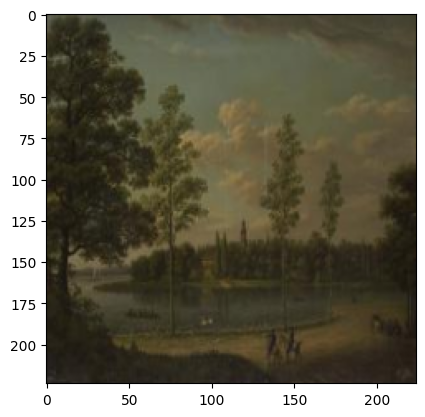

Image shape: (224, 224, 3)


In [8]:
img = cv2.imread(imgfullpath)
if img is not None:
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = cv2.resize(img, (224, 224))
  plt.imshow(img)
  plt.show()
  print("Image shape:", img.shape)
else:
  print("no img")


Function for Image Preprocessing

The function 'ExtractInput' is responsible for processing images from the specified path. The function reads images, applies necessary preprocessing steps, and returns processed images for further use.

In [9]:
height =224
width =224

def ExtractInput(path):
    X_img=[]
    y_img=[]
    for imageDir in os.listdir(ImagePath):
        try:
            img = cv2.imread(ImagePath + imageDir)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

            img = img.astype(np.float32)
            img_lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
            # resize the lightness channel to network input size, resize image to network input size
            img_lab_rs = cv2.resize(img_lab, (width, height))
            # pull out L channel
            img_l = img_lab_rs[:,:,0]
            #Extracting the ab channel
            img_ab = img_lab_rs[:,:,1:]
            img_ab = img_ab/128
            #The true color values range between -128 and 128. This is the default interval
            #in the Lab color space. By dividing them by 128, they too fall within the -1 to 1 interval.
            X_img.append(img_l)
            y_img.append(img_ab)
        except:
            pass
    X_img = np.array(X_img)
    y_img = np.array(y_img)

    return X_img,y_img

Data Preprocessing Step

In [10]:
X_,y_ = ExtractInput(ImagePath)

Defining the Neural Network Model

The function 'InstantiateModel' constructs the architecture of the convolutional neural network. It includes various layers like Conv2D, LeakyReLU, BatchNormalization, MaxPooling2D, and UpSampling2D, arranged to form the model. The function takes an input layer in_ and returns the constructed model.

In [11]:
K.clear_session()
def InstantiateModel(in_):
    model_ = Conv2D(16,(3,3),padding='same',strides=1)(in_)
    model_ = LeakyReLU()(model_)
    model_ = Conv2D(32,(3,3),padding='same',strides=1)(model_)
    model_ = LeakyReLU()(model_)
    model_ = BatchNormalization()(model_)
    model_ = MaxPooling2D(pool_size=(2,2),padding='same')(model_)

    model_ = Conv2D(64,(3,3),padding='same',strides=1)(model_)
    model_ = LeakyReLU()(model_)
    model_ = BatchNormalization()(model_)
    model_ = MaxPooling2D(pool_size=(2,2),padding='same')(model_)

    model_ = Conv2D(128,(3,3),padding='same',strides=1)(model_)
    model_ = LeakyReLU()(model_)
    model_ = BatchNormalization()(model_)

    model_ = Conv2D(256,(3,3),padding='same',strides=1)(model_)
    model_ = LeakyReLU()(model_)
    model_ = BatchNormalization()(model_)

    model_ = UpSampling2D((2, 2))(model_)
    model_ = Conv2D(128,(3,3),padding='same',strides=1)(model_)
    model_ = LeakyReLU()(model_)
    model_ = BatchNormalization()(model_)

    model_ = UpSampling2D((2, 2))(model_)
    model_ = Conv2D(64,(3,3), padding='same',strides=1)(model_)
    model_ = LeakyReLU()(model_)

    concat_ = concatenate([model_, in_])

    model_ = Conv2D(64,(3,3), padding='same',strides=1)(concat_)
    model_ = LeakyReLU()(model_)
    model_ = BatchNormalization()(model_)

    model_ = Conv2D(32,(3,3),padding='same',strides=1)(model_)
    model_ = LeakyReLU()(model_)

    model_ = Conv2D(2,(3,3), activation='tanh',padding='same',strides=1)(model_)

    return model_

Initializing the Neural Network Model

It creates an input layer Input_Sample with the specified shape, uses the InstantiateModel function to create the neural network model, and then initializes the model Model_Colourization with the input and output layers.

In [12]:
Input_Sample = Input(shape=(height, width,1))
Output_ = InstantiateModel(Input_Sample)
Model_Colourization = Model(inputs=Input_Sample, outputs=Output_)

Instructions for updating:
Colocations handled automatically by placer.


Setting the Optimizer

Here, an Adam optimizer is configured with a learning rate of 0.001 for training the neural network.

In [13]:
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.001)

Compiling the Model

 The model is compiled with the previously defined optimizer and 'mean squared error' as the loss function. The model's summary is also printed to display its architecture and parameters.

In [14]:
Model_Colourization.compile(optimizer=optimizer, loss='mean_squared_error')
Model_Colourization.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 224, 224, 16)         160       ['input_1[0][0]']             
                                                                                                  
 leaky_re_lu (LeakyReLU)     (None, 224, 224, 16)         0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 224, 224, 32)         4640      ['leaky_re_lu[0][0]']         
                                                                                              

Training the Model

In [15]:
def GenerateInputs(X_,y_):
    for i in range(len(X_)):
        X_input = X_[i].reshape(1,224,224,1)
        y_input = y_[i].reshape(1,224,224,2)
        yield (X_input,y_input)

Model_Colourization.fit(GenerateInputs(X_, y_), epochs=53, verbose=1, steps_per_epoch=38, shuffle=True)

Epoch 1/53
38/38 [==============================] - 11s 29ms/step - batch: 18.5000 - size: 1.0000 - loss: 0.0785
Epoch 2/53
38/38 [==============================] - 1s 28ms/step - batch: 18.5000 - size: 1.0000 - loss: 0.0220
Epoch 3/53
38/38 [==============================] - 1s 28ms/step - batch: 18.5000 - size: 1.0000 - loss: 0.0178
Epoch 4/53
38/38 [==============================] - 1s 28ms/step - batch: 18.5000 - size: 1.0000 - loss: 0.0186
Epoch 5/53
38/38 [==============================] - 1s 28ms/step - batch: 18.5000 - size: 1.0000 - loss: 0.0081
Epoch 6/53
38/38 [==============================] - 1s 31ms/step - batch: 18.5000 - size: 1.0000 - loss: 0.0064
Epoch 7/53
38/38 [==============================] - 1s 37ms/step - batch: 18.5000 - size: 1.0000 - loss: 0.0016
Epoch 8/53
38/38 [==============================] - 1s 36ms/step - batch: 18.5000 - size: 1.0000 - loss: 0.0194
Epoch 9/53
38/38 [==============================] - 2s 39ms/step - batch: 18.5000 - size: 1.0000 - loss

Setting the Test Image Path

In [17]:
TestImagePath="dataset/training_set/iconography/"

Evaluating the model on test data, visualizing the results, saving the model, or any post-processing steps required.

In [18]:
def ExtractTestInput(ImagePath):
    img = cv2.imread(ImagePath)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img_ = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    img_ = cv2.cvtColor(img_, cv2.COLOR_RGB2Lab)
    img_=img_.astype(np.float32)
    # resize image to network input size
    img_lab_rs = cv2.resize(img_, (width, height))
    # pull out L channel
    img_l = img_lab_rs[:,:,0]
    img_l_reshaped = img_l.reshape(1,224,224,1)

    return img_l_reshaped

In [19]:
ImagePath=TestImagePath+"15.jpg"
image_for_test = ExtractTestInput(ImagePath)
Prediction = Model_Colourization.predict(image_for_test)
Prediction = Prediction*128
Prediction=Prediction.reshape(224,224,2)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


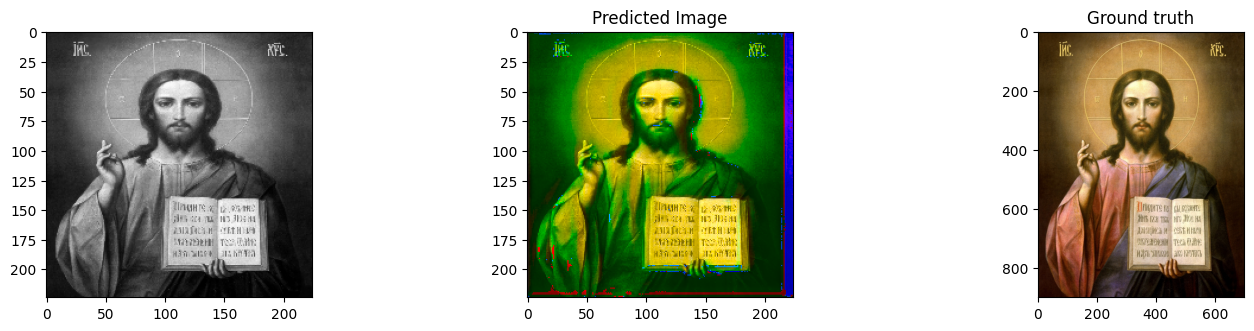

In [20]:
plt.figure(figsize=(30,20))
plt.subplot(5,5,1)
img = cv2.imread(TestImagePath+"15.jpg")
img_1 = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img = cv2.cvtColor(img_1, cv2.COLOR_RGB2GRAY)
img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
img = cv2.resize(img, (224, 224))
plt.imshow(img)

plt.subplot(5,5,1+1)
img_ = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
img_[:,:,1:] = Prediction
img_ = cv2.cvtColor(img_, cv2.COLOR_Lab2RGB)
plt.title("Predicted Image")
plt.imshow(img_)

plt.subplot(5,5,1+2)
plt.title("Ground truth")
plt.imshow(img_1)

In [21]:
ImagePath=TestImagePath+"314.jpg"
image_for_test = ExtractTestInput(ImagePath)
Prediction_1 = Model_Colourization.predict(image_for_test)
Prediction_1 = Prediction_1*128
Prediction_1=Prediction_1.reshape(224,224,2)

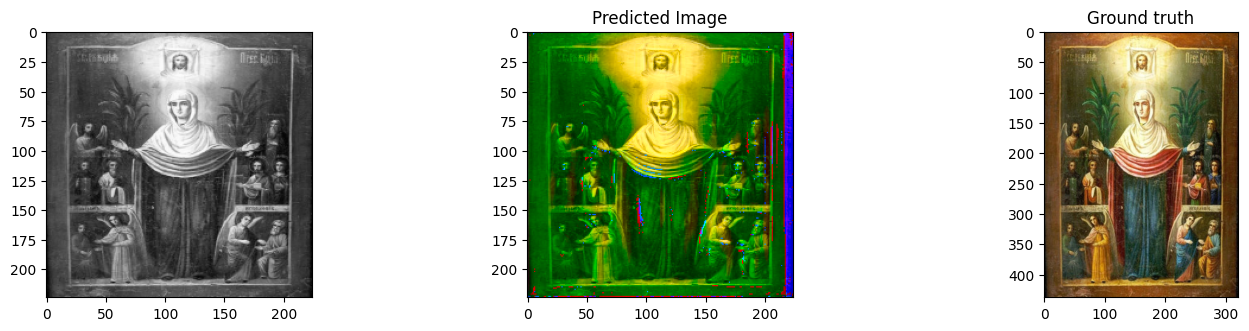

In [22]:
plt.figure(figsize=(30,20))
plt.subplot(5,5,1)
img = cv2.imread(TestImagePath+"314.jpg")
img_1 = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img = cv2.cvtColor(img_1, cv2.COLOR_RGB2GRAY)
img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
img = cv2.resize(img, (224, 224))
plt.imshow(img)

plt.subplot(5,5,1+1)
img_ = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
img_[:,:,1:] = Prediction_1
img_ = cv2.cvtColor(img_, cv2.COLOR_Lab2RGB)
plt.title("Predicted Image")
plt.imshow(img_)

plt.subplot(5,5,1+2)
plt.title("Ground truth")
plt.imshow(img_1)

In [23]:
TestImagePath="dataset/training_set/sculpture/240.jpg"
image_for_test = ExtractTestInput(TestImagePath)
Prediction_3 = Model_Colourization.predict(image_for_test)
Prediction_3 = Prediction_3*128
Prediction_3=Prediction_3.reshape(224,224,2)

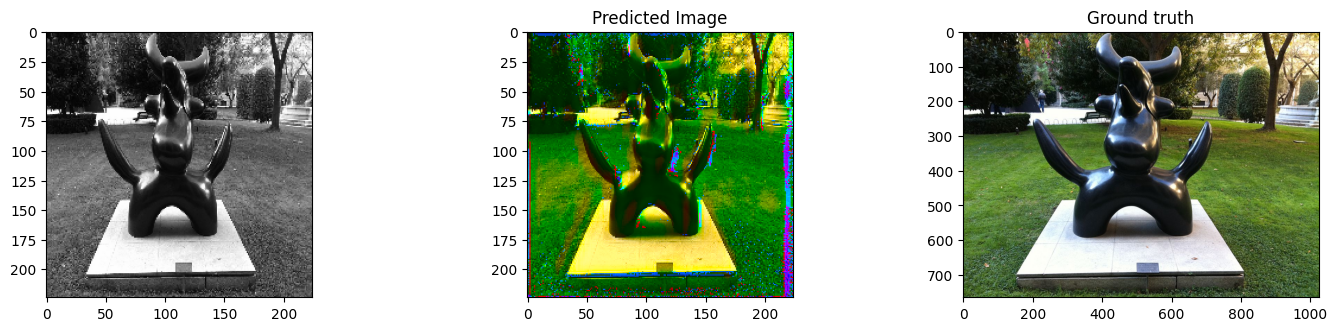

In [24]:
plt.figure(figsize=(30,20))
plt.subplot(5,5,1)
img = cv2.imread(TestImagePath)
img_1 = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img = cv2.cvtColor(img_1, cv2.COLOR_RGB2GRAY)
img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
img = cv2.resize(img, (224, 224))
plt.imshow(img)

plt.subplot(5,5,1+1)
img_ = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
img_[:,:,1:] = Prediction_3
img_ = cv2.cvtColor(img_, cv2.COLOR_Lab2RGB)
plt.title("Predicted Image")
plt.imshow(img_)

plt.subplot(5,5,1+2)
plt.title("Ground truth")
plt.imshow(img_1)

In [25]:
TestImagePath="dataset/training_set/painting/1601.jpg"
image_for_test = ExtractTestInput(TestImagePath)
Prediction_4 = Model_Colourization.predict(image_for_test)
Prediction_4 = Prediction_4*128
Prediction_4=Prediction_4.reshape(224,224,2)

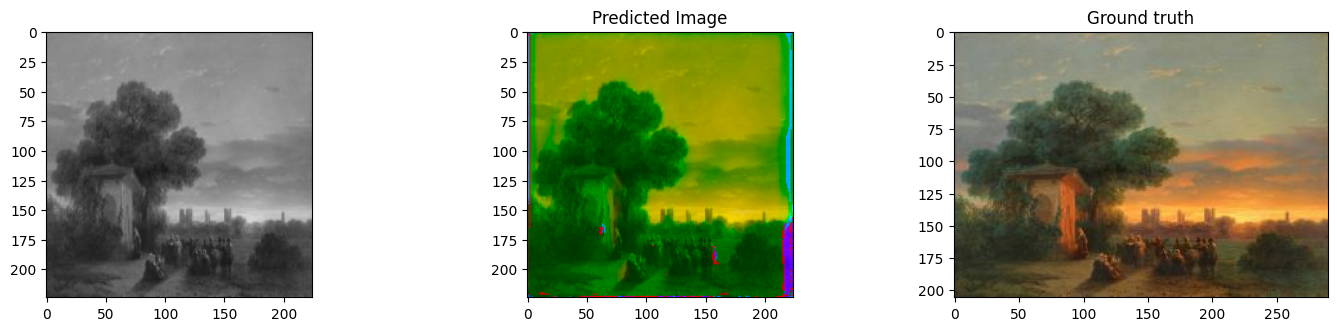

In [26]:
plt.figure(figsize=(30,20))
plt.subplot(5,5,1)
img = cv2.imread(TestImagePath)
img_1 = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img = cv2.cvtColor(img_1, cv2.COLOR_RGB2GRAY)
img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
img = cv2.resize(img, (224, 224))
plt.imshow(img)

plt.subplot(5,5,1+1)
img_ = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
img_[:,:,1:] = Prediction_4
img_ = cv2.cvtColor(img_, cv2.COLOR_Lab2RGB)
plt.title("Predicted Image")
plt.imshow(img_)

plt.subplot(5,5,1+2)
plt.title("Ground truth")
plt.imshow(img_1)

In [27]:
TestImagePath="dataset/training_set/painting/1577.jpg"
image_for_test = ExtractTestInput(TestImagePath)
Prediction_5 = Model_Colourization.predict(image_for_test)
Prediction_5 = Prediction_5*128
Prediction_5=Prediction_5.reshape(224,224,2)

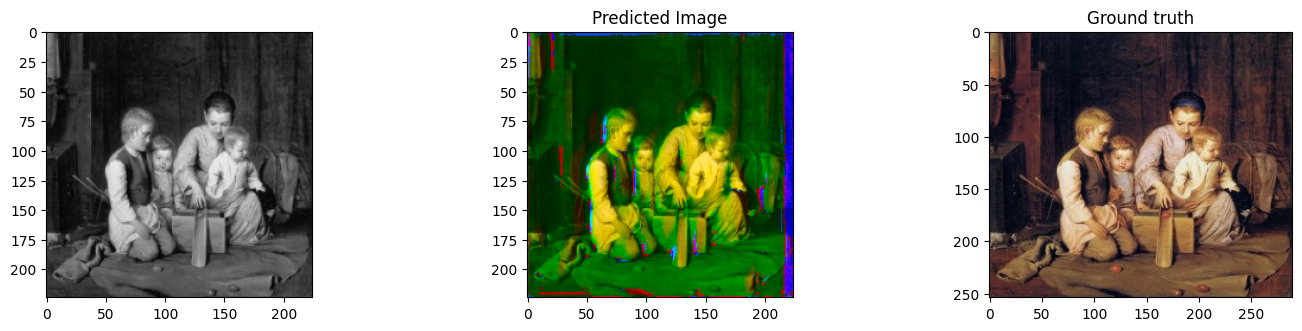

In [28]:
plt.figure(figsize=(30,20))
plt.subplot(5,5,1)
img = cv2.imread(TestImagePath)
img_1 = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img = cv2.cvtColor(img_1, cv2.COLOR_RGB2GRAY)
img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
img = cv2.resize(img, (224, 224))
plt.imshow(img)

plt.subplot(5,5,1+1)
img_ = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
img_[:,:,1:] = Prediction_5
img_ = cv2.cvtColor(img_, cv2.COLOR_Lab2RGB)
plt.title("Predicted Image")
plt.imshow(img_)

plt.subplot(5,5,1+2)
plt.title("Ground truth")
plt.imshow(img_1)